### import libraries

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import math   # for mathematical operations
import pandas as pd
from tensorflow.keras.preprocessing import image   # for preprocessing the images
from skimage.transform import resize   # for resizing images
from glob import glob
from tqdm import tqdm
import random
import pathlib
import itertools
import collections
import tensorflow as tf
import imageio
from IPython import display
from urllib import request
# from tensorflow_docs.vis import embed
import keras

2023-08-20 08:58:13.612437: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **Reading and spletting the dataset**

In [2]:
#readind the dataset
model_df = pd.read_csv('model_df.csv')

#spletting the dataset using train_test_split
def split_dataset(df, test_size=0.2, random_state=42):
    X = df.drop('label', axis=1)
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    train_df = X_train
    train_df['label'] = y_train
    test_df = X_test
    test_df['label'] = y_test
    return train_df, test_df

train_df, test_df = split_dataset(model_df)

In [3]:
#the dataset containes the id, title, path, and label of the video
train_df.head(3)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,id,title,path,new_path,label
1012,1012,1012,1013.0,6967707383166536962,Trả lời @uyenthanh204 uiya tui che mắt rồi ko ...,/content/drive/My Drive/videos/,videos/videos/,1
1653,1653,1653,1685.0,8EZ941fazGQ,Jealous Kisses - Sweet Kiss #lgbt #lgbtq #blsh...,/content/drive/My Drive/youtubeShort/,youtubeShort/youtubeShort/,1
1785,1785,1785,1835.0,5FM0ARekfOU,PRANKING MY BI FRIEND 🏳️‍🌈 #shorts #pride,/content/drive/My Drive/youtubeShort/,youtubeShort/youtubeShort/,1


In [8]:
print("Number of the training videos:", len(train_df))
print("Number of the testing videos:", len(test_df))

Number of the training videos: 1804
Number of the testing videos: 451


## **using CNN-RNN to extract images features**

### **CNN features extraction**

**definind the CNN model (inceptionV3)**

In [5]:
#defining the 'inceptionV3' feature extraction model
#takes the video frame and return a 2048 representaion of the frame
def CNN_MODEL():
    #setting the image size
    img_size = (244, 126, 3)
    
    #defining the keras model
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=img_size,
    )
    
    
    #defining the input and the neccassery preprocessing to be done on it
    preprocess_input = keras.applications.inception_v3.preprocess_input
    inputs = keras.Input(img_size)
    preprocessed = preprocess_input(inputs)
    
    #finalizing defining the model
    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

#run the model and extract frame features
feature_extractor = CNN_MODEL()

**processing videos and extracting features functions**,
these 2 functions were taken from this tutorial and modified:
https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub

In [9]:
#load video funcation takees the video and return a numpy array of resized frames from it.
def get_frames(idx, path, max_frames=0, resize=(244, 126)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            #ret is true if the video's frames are read successfully
            ret, frame = cap.read()
            if not ret:
                print(idx)
                break
            #resize and append the frames to the frame array
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                print(idx)
                break

    finally:
        cap.release()
    return np.array(frames)

In [11]:
#loop over all videos, load frames then extract cnn features
#you don't have to run this function, there's pre-extracted save features you can load in the cell bellow
def get_cnn_features(df):
    num_samples = len(df)
    video_ids = df['id']
    labels = df['label']
    video_filenames = [f'{id}.mp4' for id in video_ids]
    video_directory = df['new_path']
    video_paths = [os.path.join(vd, vf) for vd, vf in zip(video_directory, video_filenames)]
    MAX_SEQ_LENGTH = 30
    
    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # For each video.
    for idx, path in tqdm(enumerate(video_paths), total=len(video_paths), desc="Processing videos"):
        if(os.path.isfile(path)):
            
            # Gather all its frames and add a batch dimension.
            frames = load_video(idx, path)
            frames = frames[None, ...]

            # Initialize placeholders to store the masks and features of the current video.
            temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
            temp_frame_features = np.zeros(
                shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
            )

            # Extract features from the frames of the current video.
            for i, batch in enumerate(frames):
                video_length = batch.shape[0]
                length = min(MAX_SEQ_LENGTH, video_length)
                for j in range(length):
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :], verbose=0
                    )
                temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

            frame_features[idx,] = temp_frame_features.squeeze()
            frame_masks[idx,] = temp_frame_mask.squeeze()
        else:
            print(idx, 'this file do not exist')
    return (frame_features, frame_masks), labels

**run the function and extract features**

In [10]:
#extracting train features
train_data, train_labels = get_cnn_features(train_df)

#saving the training features
np.save('train_data.npy', train_data[0])
np.save('train_labels.npy', train_labels)
np.save('train_masks.npy', train_data[1])

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

0 videos/videos/6967707383166536962.mp4 True


[NULL @ 0x55d0ca120ac0] Invalid NAL unit size (6855 > 1304).
[NULL @ 0x55d0ca120ac0] missing picture in access unit with size 1308
[h264 @ 0x55d0ca14c0c0] Invalid NAL unit size (6855 > 1304).
[h264 @ 0x55d0ca14c0c0] Error splitting the input into NAL units.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55d0ca124080] stream 1, offset 0x56cb30: partial file
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55d0ca124080] stream 0, offset 0x56cbe3: partial file


200 youtubeShort/youtubeShort/1A13fZSqUe8.mp4 True


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55d1247dc540] moov atom not found
[ERROR:0@1162.541] global cap.cpp:164 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.8.0) /io/opencv/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




400 videos/videos/7244410015879138566.mp4 True


[NULL @ 0x55d162458c00] Invalid NAL unit size (8094 > 5488).
[NULL @ 0x55d162458c00] missing picture in access unit with size 5492
[h264 @ 0x55d16592d680] Invalid NAL unit size (8094 > 5488).
[h264 @ 0x55d16592d680] Error splitting the input into NAL units.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55d1621c4100] stream 1, offset 0x100a2e: partial file
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55d1621c4100] stream 0, offset 0x100ae3: partial file


600 youtubeShort/youtubeShort/kqrIhMDl-NA.mp4 True
800 videos/videos/7236813239932292358.mp4 True


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55d1e95bf900] moov atom not found
[ERROR:0@3281.783] global cap.cpp:164 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.8.0) /io/opencv/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




1000 videos/videos/7251912625964010753.mp4 True
1200 youtubeShort/youtubeShort/vnwdJaP5jAk.mp4 True


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55d27d075680] moov atom not found
[ERROR:0@4866.305] global cap.cpp:164 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.8.0) /io/opencv/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




1400 youtubeShort/youtubeShort/lfDMMN9u4OQ.mp4 True


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55d2d3803340] moov atom not found
[ERROR:0@5749.631] global cap.cpp:164 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.8.0) /io/opencv/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




1600 videos/videos/7100584806026726658.mp4 True


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55d320693a80] moov atom not found
[ERROR:0@6853.072] global cap.cpp:164 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.8.0) /io/opencv/modules/videoio/src/cap_images.cpp:267: error: (-215:Assertion failed) number < max_number in function 'icvExtractPattern'




1800 videos/videos/6999358038507375873.mp4 True
Frame features in train set: (1804, 20, 2048)
Frame masks in train set: (1804, 20)


In [12]:
#extracting test features
test_data, test_labels = get_cnn_features(test_df)

#saving test features
np.save('test_data_inceptionV3.npy', test_data[0])
np.save('test_labels_inceptionV3.npy', test_labels)
np.save('test_masks_InceptionV3.npy', test_data[1])

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

0 videos/videos/7258545023791222018.mp4 True


[NULL @ 0x55d34dcc3200] Invalid NAL unit size (1058 > 869).
[NULL @ 0x55d34dcc3200] missing picture in access unit with size 873
[h264 @ 0x55d34dcca780] Invalid NAL unit size (1058 > 869).
[h264 @ 0x55d34dcca780] Error splitting the input into NAL units.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55d34dcd4ac0] stream 0, offset 0x41e0bd: partial file
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55d34dcd4ac0] stream 1, offset 0x41e408: partial file


200 youtubeShort/youtubeShort/jSpKqilPYII.mp4 True
400 youtubeShort/youtubeShort/SNKSdzkM0_I.mp4 True
Frame features in train set: (1804, 20, 2048)
Frame masks in train set: (1804, 20)


In [3]:
#loading test and training features
#this is used if you don't want to run the function
train_features = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')
train_masks = np.load('train_masks.npy')
train_data = (train_features, train_masks)

test_features = np.load('test_data.npy')
test_labels = np.load('test_labels.npy')
test_masks = np.load('test_masks.npy')
test_data = (test_features, test_masks)

### **RNN features extraction**

In [17]:
from tensorflow import keras

def RNN_MODEL():
    MAX_SEQ_LENGTH = 20
    NUM_FEATURES = 2048

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")
    
    # Use LSTM layers
    x = keras.layers.LSTM(1028, return_sequences=True)(frame_features_input,  mask=mask_input)
    x = keras.layers.LSTM(512, return_sequences=True)(frame_features_input,  mask=mask_input)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.LSTM(256, return_sequences=True)(x)
    x = keras.layers.LSTM(128)(x)

    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(256, activation="relu")(x)

    # Binary classification output
    output = keras.layers.Dense(1, activation="sigmoid")(x)
    
    rnn_model = keras.Model([frame_features_input,mask_input] , output)

    rnn_model.compile(
        loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"]
    )
    return rnn_model

In [48]:
from tensorflow import keras

def train_rnn_model():
    # Set a filepath to save the best weights
    filepath = "/tmp/best_weights_resnet.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True,
                                                 monitor='val_accuracy', mode='max',
                                                 save_best_only=True, verbose=1)
    
    epochs = 40
    batch_size = 32
    
    model = RNN_MODEL()
    
    # Train the model with the checkpoint callback
    history = model.fit(
        train_data,  # Input data
        train_labels,                                 # Labels
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,                         # Validation data
        callbacks=[checkpoint]                        # Add checkpoint to callbacks
    )
    
    # Load the best weights into the model
    model.load_weights(filepath)
    
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    
    # If you want to return the actual weight values, you can use:
    # best_weights = model.get_weights()

    return history, model  #, best_weights  # uncomment this if returning actual weights


In [34]:
history, rnn_model = train_rnn_model()

Epoch 1/30
26/26 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.5373
Epoch 1: val_accuracy improved from -inf to 0.53591, saving model to /tmp/best_weights_resnet.h5
26/26 [==============================] - 22s 518ms/step - loss: 0.6891 - accuracy: 0.5373 - val_loss: 0.6849 - val_accuracy: 0.5359
Epoch 2/30
26/26 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.5669
Epoch 2: val_accuracy improved from 0.53591 to 0.54696, saving model to /tmp/best_weights_resnet.h5
26/26 [==============================] - 10s 370ms/step - loss: 0.6794 - accuracy: 0.5669 - val_loss: 0.6757 - val_accuracy: 0.5470
Epoch 3/30
26/26 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.6014
Epoch 3: val_accuracy improved from 0.54696 to 0.65746, saving model to /tmp/best_weights_resnet.h5
26/26 [==============================] - 9s 353ms/step - loss: 0.6670 - accuracy: 0.6014 - val_loss: 0.6612 - val_accuracy: 0.6575
Epoch 4/30
26/26 [========

In [51]:
rnn_model.save('rnn_model_inception.h5')

In [11]:
#experiments
history10, rnn_model10 = train_rnn_model()

Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.5204
Epoch 1: val_accuracy improved from -inf to 0.52078, saving model to /tmp/best_weights_resnet.h5
23/23 [==============================] - 20s 526ms/step - loss: 0.6922 - accuracy: 0.5204 - val_loss: 0.6922 - val_accuracy: 0.5208
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 0.6877 - accuracy: 0.5454
Epoch 2: val_accuracy did not improve from 0.52078
23/23 [==============================] - 8s 369ms/step - loss: 0.6877 - accuracy: 0.5454 - val_loss: 0.6892 - val_accuracy: 0.5180
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.6829 - accuracy: 0.5759
Epoch 3: val_accuracy improved from 0.52078 to 0.52632, saving model to /tmp/best_weights_resnet.h5
23/23 [==============================] - 9s 391ms/step - loss: 0.6829 - accuracy: 0.5759 - val_loss: 0.6850 - val_accuracy: 0.5263
Epoch 4/30
23/23 [==============================] - ETA: 0s - loss: 0.6758 -

In [18]:
history9, rnn_model9 = train_rnn_model()

Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5094
Epoch 1: val_accuracy improved from -inf to 0.53740, saving model to /tmp/best_weights_resnet.h5
23/23 [==============================] - 21s 547ms/step - loss: 0.6927 - accuracy: 0.5094 - val_loss: 0.6898 - val_accuracy: 0.5374
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.5565
Epoch 2: val_accuracy did not improve from 0.53740
23/23 [==============================] - 9s 408ms/step - loss: 0.6844 - accuracy: 0.5565 - val_loss: 0.6848 - val_accuracy: 0.5263
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.6772 - accuracy: 0.5579
Epoch 3: val_accuracy improved from 0.53740 to 0.55125, saving model to /tmp/best_weights_resnet.h5
23/23 [==============================] - 9s 410ms/step - loss: 0.6772 - accuracy: 0.5579 - val_loss: 0.6770 - val_accuracy: 0.5512
Epoch 4/30
23/23 [==============================] - ETA: 0s - loss: 0.6692 -

In [35]:
history8, rnn_model8 = train_rnn_model()

Epoch 1/30
46/46 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.5398
Epoch 1: val_accuracy improved from -inf to 0.48476, saving model to /tmp/best_weights_resnet.h5
46/46 [==============================] - 34s 539ms/step - loss: 0.6869 - accuracy: 0.5398 - val_loss: 0.6899 - val_accuracy: 0.4848
Epoch 2/30
46/46 [==============================] - ETA: 0s - loss: 0.6716 - accuracy: 0.5530
Epoch 2: val_accuracy improved from 0.48476 to 0.54571, saving model to /tmp/best_weights_resnet.h5
46/46 [==============================] - 24s 510ms/step - loss: 0.6716 - accuracy: 0.5530 - val_loss: 0.6704 - val_accuracy: 0.5457
Epoch 3/30
46/46 [==============================] - ETA: 0s - loss: 0.6469 - accuracy: 0.6577
Epoch 3: val_accuracy improved from 0.54571 to 0.55402, saving model to /tmp/best_weights_resnet.h5
46/46 [==============================] - 22s 478ms/step - loss: 0.6469 - accuracy: 0.6577 - val_loss: 0.6530 - val_accuracy: 0.5540
Epoch 4/30
46/46 [=======

In [13]:
history7, rnn_model7 = train_rnn_model()

Epoch 1/30
46/46 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.5454
Epoch 1: val_accuracy improved from -inf to 0.53186, saving model to /tmp/best_weights_resnet.h5
46/46 [==============================] - 34s 542ms/step - loss: 0.6869 - accuracy: 0.5454 - val_loss: 0.6851 - val_accuracy: 0.5319
Epoch 2/30
46/46 [==============================] - ETA: 0s - loss: 0.6711 - accuracy: 0.5897
Epoch 2: val_accuracy improved from 0.53186 to 0.62050, saving model to /tmp/best_weights_resnet.h5
46/46 [==============================] - 21s 451ms/step - loss: 0.6711 - accuracy: 0.5897 - val_loss: 0.6686 - val_accuracy: 0.6205
Epoch 3/30
46/46 [==============================] - ETA: 0s - loss: 0.6461 - accuracy: 0.6674
Epoch 3: val_accuracy improved from 0.62050 to 0.65374, saving model to /tmp/best_weights_resnet.h5
46/46 [==============================] - 16s 354ms/step - loss: 0.6461 - accuracy: 0.6674 - val_loss: 0.6418 - val_accuracy: 0.6537
Epoch 4/30
46/46 [=======

In [18]:
history6, rnn_model6 = train_rnn_model()

Epoch 1/30
46/46 [==============================] - ETA: 0s - loss: 0.6873 - accuracy: 0.5475
Epoch 1: val_accuracy improved from -inf to 0.55679, saving model to /tmp/best_weights_resnet.h5
46/46 [==============================] - 25s 366ms/step - loss: 0.6873 - accuracy: 0.5475 - val_loss: 0.6794 - val_accuracy: 0.5568
Epoch 2/30
46/46 [==============================] - ETA: 0s - loss: 0.6649 - accuracy: 0.6452
Epoch 2: val_accuracy improved from 0.55679 to 0.60942, saving model to /tmp/best_weights_resnet.h5
46/46 [==============================] - 13s 289ms/step - loss: 0.6649 - accuracy: 0.6452 - val_loss: 0.6559 - val_accuracy: 0.6094
Epoch 3/30
46/46 [==============================] - ETA: 0s - loss: 0.6281 - accuracy: 0.7069
Epoch 3: val_accuracy improved from 0.60942 to 0.75069, saving model to /tmp/best_weights_resnet.h5
46/46 [==============================] - 14s 307ms/step - loss: 0.6281 - accuracy: 0.7069 - val_loss: 0.6102 - val_accuracy: 0.7507
Epoch 4/30
46/46 [=======

In [64]:
_3, rnn_model3 = train_rnn_model()

Epoch 1/30
23/23 [==============================] - 24s 570ms/step - loss: 0.6915 - accuracy: 0.5232 - val_loss: 0.6908 - val_accuracy: 0.5042
Epoch 2/30
23/23 [==============================] - 10s 416ms/step - loss: 0.6740 - accuracy: 0.5814 - val_loss: 0.6800 - val_accuracy: 0.5180
Epoch 3/30
23/23 [==============================] - 10s 427ms/step - loss: 0.6593 - accuracy: 0.6140 - val_loss: 0.6606 - val_accuracy: 0.6648
Epoch 4/30
23/23 [==============================] - 10s 424ms/step - loss: 0.6361 - accuracy: 0.7089 - val_loss: 0.6386 - val_accuracy: 0.6870
Epoch 5/30
23/23 [==============================] - 10s 417ms/step - loss: 0.6086 - accuracy: 0.7429 - val_loss: 0.6068 - val_accuracy: 0.7396
Epoch 6/30
23/23 [==============================] - 11s 477ms/step - loss: 0.5767 - accuracy: 0.7623 - val_loss: 0.5695 - val_accuracy: 0.7507
Epoch 7/30
23/23 [==============================] - 10s 419ms/step - loss: 0.5383 - accuracy: 0.7852 - val_loss: 0.5502 - val_accuracy: 0.7396

In [20]:
import pickle

with open('training_history_inception.pkl', 'wb') as file:
    pickle.dump(history.history, file)

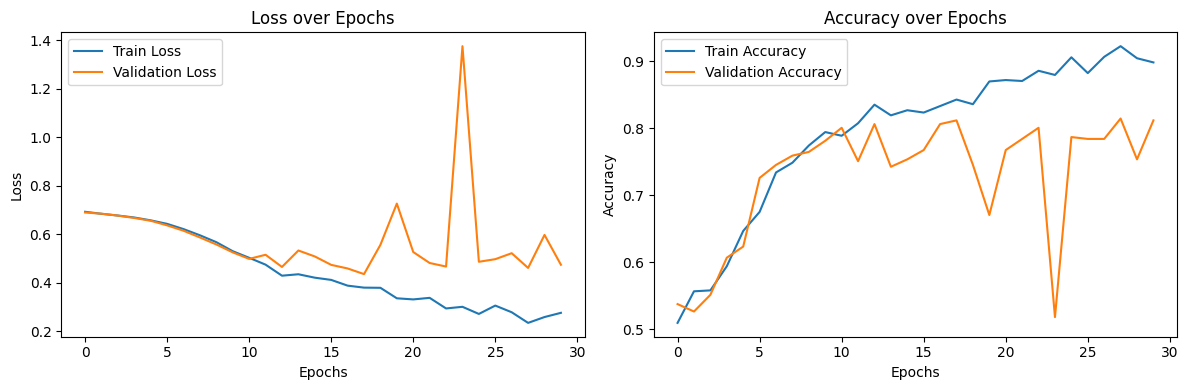

In [20]:
#plot CNN-RNN results
import matplotlib.pyplot as plt

# Plotting the loss for training and validation data
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the accuracy for training and validation data
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()


# Save the figure to a file
plt.savefig('training_plots_inceptoin.png', dpi=300)
plt.show()

In [35]:
#extract the training features from the RNN model
rnn_feature_extractor = keras.Model(
    inputs=rnn_model.inputs,
    outputs=rnn_model.layers[-2].output
)

extracted_image_features = rnn_feature_extractor.predict(train_data)
image_features_shape = extracted_image_features.shape
print(f"video features shape: {image_features_shape}")

57/57 [==============================] - 7s 73ms/step
video features shape: (1804, 256)


In [36]:
#extract the testing features from the RNN model
rnn_feature_extractor = keras.Model(
    inputs=rnn_model.inputs,
    outputs=rnn_model.layers[-2].output
)

test_extracted_image_features = rnn_feature_extractor.predict(test_data)
test_image_features_shape = test_extracted_image_features.shape
print(f"video features shape: {test_image_features_shape}")

15/15 [==============================] - 4s 73ms/step
video features shape: (451, 256)


## **Getting text embeddings**

In [5]:
from transformers import TFBertModel, BertTokenizer

2023-08-15 04:57:00.060544: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


**get bert multingual model to extract text features**

In [6]:
#load bert model and its tokenizer
bert_model = TFBertModel.from_pretrained("bert-base-multilingual-cased")
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

**get titles and replace empty fields with UNK**

In [10]:
train_titles = train_df['title']
train_titles = [title if isinstance(title, str) else "[UNK]" for title in train_titles]

test_titles = test_df['title']
test_titles = [title if isinstance(title, str) else "[UNK]" for title in test_titles]

**get the embeddings**

In [11]:
input_ids = tokenizer(train_titles, return_tensors="tf", padding=True, truncation=True, max_length=128)
outputs = bert_model(input_ids)
train_embeddings = outputs[1]

In [58]:
input_ids_test = tokenizer(test_titles, return_tensors="tf", padding=True, truncation=True, max_length=128)
outputs_test = bert_model(input_ids_test)
test_embeddings = outputs_test[1]

In [15]:
np.save('train_embeddings.npy', train_embeddings.numpy())
np.save('test_embeddings.npy', test_embeddings.numpy())

In [41]:
train_embeddings.numpy().shape

(1804, 768)

In [48]:
extracted_image_features.shape

(1804, 8)

In [23]:
train_embeddings = np.load('train_embeddings.npy')
test_embeddings = np.load('test_embeddings.npy')

## **Fused network**

In [37]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K

def F1_Score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall) / (precision + recall + K.epsilon())
    
    return f1_val

In [43]:
#create the fused model, this model combine the features of the frames and the embeddings of the titles
def FUSED_NN():
    # Assuming image_features is the output tensor from your image model
    image_input = tf.keras.Input(shape=(256, ), name="image_input")  # replace image_features_shape with the shape of your image features

    # BERT embeddings
    text_input = tf.keras.Input(shape=(768, ), name="text_input")  # BERT base models have an output dimension of 768

    fused = tf.keras.layers.Concatenate()([image_input, text_input])

    # Fully Connected Layers
    dense = tf.keras.layers.Dense(1208, activation='relu')(fused)
    dense = tf.keras.layers.Dense(512, activation='relu')(fused)
    dense = tf.keras.layers.Dense(256, activation='relu')(dense)
    dense = tf.keras.layers.Dense(126, activation='relu')(dense)
    # Output layer for binary classification
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)  # Single neuron with sigmoid activation

    # Construct the model
    fused_model = tf.keras.Model(inputs=[image_input, text_input], outputs=output)

    # Compile the model for binary classification
    fused_model.compile(optimizer='adam', 
                    loss='binary_crossentropy', 
                    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), F1_Score])    
    return fused_model

In [44]:
from tensorflow import keras

def train_fused_model():
    # Set a filepath to save the best weights
    filepath = "/tmp/best_weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True,
                                                 monitor='val_accuracy', mode='max',
                                                 save_best_only=True, verbose=1)
    
    epochs = 70
    batch_size = 64
    
    image_features_train = extracted_image_features
    text_features_train = train_embeddings
    
    model = FUSED_NN()
    
    # Train the model with the checkpoint callback
    history = model.fit(
        [image_features_train, text_features_train],  # Input data
        train_labels,                                 # Labels
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1,                         # Validation data
        callbacks=[checkpoint]                        # Add checkpoint to callbacks
    )
    
    # Load the best weights into the model
    model.load_weights(filepath)
    
    _, accuracy, precision, recall, f1_score = model.evaluate([test_extracted_image_features, test_embeddings], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test precision: {round(precision * 100, 2)}%")
    print(f"Test recall: {round(recall * 100, 2)}%")
    print(f"Test f1_score: {round(f1_score * 100, 2)}%")
    
    # If you want to return the actual weight values, you can use:
    # best_weights = model.get_weights()

    return history, model  #, best_weights  # uncomment this if returning actual weights


In [45]:
#experiments (diffrent batch size, epochs, and layer sizes)
history7, fused_model7 = train_fused_model()

Epoch 1/70
25/26 [===========================>..] - ETA: 0s - loss: 0.2029 - accuracy: 0.9187 - precision: 0.9316 - recall: 0.9116 - F1_Score: 0.9065       
Epoch 1: val_accuracy improved from -inf to 0.81215, saving model to /tmp/best_weights.h5
26/26 [==============================] - 2s 25ms/step - loss: 0.2040 - accuracy: 0.9193 - precision: 0.9326 - recall: 0.9118 - F1_Score: 0.9086 - val_loss: 0.6566 - val_accuracy: 0.8122 - val_precision: 0.8452 - val_recall: 0.7717 - val_F1_Score: 0.8057
Epoch 2/70
26/26 [==============================] - ETA: 0s - loss: 0.1302 - accuracy: 0.9630 - precision: 0.9658 - recall: 0.9635 - F1_Score: 0.9651
Epoch 2: val_accuracy improved from 0.81215 to 0.84530, saving model to /tmp/best_weights.h5
26/26 [==============================] - 0s 12ms/step - loss: 0.1302 - accuracy: 0.9630 - precision: 0.9658 - recall: 0.9635 - F1_Score: 0.9651 - val_loss: 0.5609 - val_accuracy: 0.8453 - val_precision: 0.8556 - val_recall: 0.8370 - val_F1_Score: 0.8440
Ep

In [42]:
history6, fused_model6 = train_fused_model()

Epoch 1/50
46/51 [==========================>...] - ETA: 0s - loss: 0.1874 - accuracy: 0.9423 - precision: 0.9565 - recall: 0.9331 - F1_Score: 0.9373
Epoch 1: val_accuracy improved from -inf to 0.83978, saving model to /tmp/best_weights.h5
51/51 [==============================] - 2s 18ms/step - loss: 0.1791 - accuracy: 0.9452 - precision: 0.9568 - recall: 0.9376 - F1_Score: 0.9411 - val_loss: 0.5665 - val_accuracy: 0.8398 - val_precision: 0.8247 - val_recall: 0.8696 - val_F1_Score: 0.8418
Epoch 2/50
47/51 [==========================>...] - ETA: 0s - loss: 0.1200 - accuracy: 0.9634 - precision: 0.9619 - recall: 0.9681 - F1_Score: 0.9642
Epoch 2: val_accuracy did not improve from 0.83978
51/51 [==============================] - 0s 8ms/step - loss: 0.1237 - accuracy: 0.9624 - precision: 0.9603 - recall: 0.9682 - F1_Score: 0.9636 - val_loss: 0.4826 - val_accuracy: 0.8011 - val_precision: 0.7692 - val_recall: 0.8696 - val_F1_Score: 0.8096
Epoch 3/50
44/51 [========================>.....] - 

In [40]:
history5, fused_model5 = train_fused_model()

Epoch 1/50
24/26 [==========================>...] - ETA: 0s - loss: 0.1960 - accuracy: 0.9401 - precision: 0.9397 - recall: 0.9467 - F1_Score: 0.9454
Epoch 1: val_accuracy improved from -inf to 0.82320, saving model to /tmp/best_weights.h5
26/26 [==============================] - 1s 21ms/step - loss: 0.1893 - accuracy: 0.9409 - precision: 0.9394 - recall: 0.9482 - F1_Score: 0.9464 - val_loss: 0.5508 - val_accuracy: 0.8232 - val_precision: 0.8488 - val_recall: 0.7935 - val_F1_Score: 0.8206
Epoch 2/50
22/26 [========================>.....] - ETA: 0s - loss: 0.1283 - accuracy: 0.9595 - precision: 0.9589 - recall: 0.9653 - F1_Score: 0.9621
Epoch 2: val_accuracy improved from 0.82320 to 0.83425, saving model to /tmp/best_weights.h5
26/26 [==============================] - 0s 15ms/step - loss: 0.1250 - accuracy: 0.9612 - precision: 0.9613 - recall: 0.9647 - F1_Score: 0.9609 - val_loss: 0.6876 - val_accuracy: 0.8343 - val_precision: 0.8523 - val_recall: 0.8152 - val_F1_Score: 0.8296
Epoch 3/5

In [46]:
fused_model5.save('fused_model_83.h5')

In [32]:
history4, fused_model4 = train_fused_model()

Epoch 1/50
25/26 [===========================>..] - ETA: 0s - loss: 0.2438 - accuracy: 0.9306 - precision: 0.9263 - recall: 0.9429 - F1_Score: 0.9347
Epoch 1: val_accuracy improved from -inf to 0.82320, saving model to /tmp/best_weights.h5
26/26 [==============================] - 3s 26ms/step - loss: 0.2413 - accuracy: 0.9316 - precision: 0.9272 - recall: 0.9435 - F1_Score: 0.9372 - val_loss: 0.5039 - val_accuracy: 0.8232 - val_precision: 0.8125 - val_recall: 0.8478 - val_F1_Score: 0.8260
Epoch 2/50
22/26 [========================>.....] - ETA: 0s - loss: 0.1473 - accuracy: 0.9524 - precision: 0.9507 - recall: 0.9596 - F1_Score: 0.9545
Epoch 2: val_accuracy improved from 0.82320 to 0.83425, saving model to /tmp/best_weights.h5
26/26 [==============================] - 0s 10ms/step - loss: 0.1472 - accuracy: 0.9513 - precision: 0.9446 - recall: 0.9635 - F1_Score: 0.9533 - val_loss: 0.4708 - val_accuracy: 0.8343 - val_precision: 0.8163 - val_recall: 0.8696 - val_F1_Score: 0.8369
Epoch 3/5

In [29]:
#best one
history, fused_model = train_fused_model()

Epoch 1/50
38/46 [=======================>......] - ETA: 0s - loss: 0.3375 - accuracy: 0.8758 - precision: 0.8664 - recall: 0.9077 - F1_Score: 0.8862
Epoch 1: val_accuracy improved from -inf to 0.79778, saving model to /tmp/best_weights.h5
46/46 [==============================] - 2s 17ms/step - loss: 0.3392 - accuracy: 0.8704 - precision: 0.8718 - recall: 0.8866 - F1_Score: 0.8567 - val_loss: 0.4958 - val_accuracy: 0.7978 - val_precision: 0.7237 - val_recall: 0.9429 - val_F1_Score: 0.8067
Epoch 2/50
42/46 [==========================>...] - ETA: 0s - loss: 0.2404 - accuracy: 0.9070 - precision: 0.9163 - recall: 0.9100 - F1_Score: 0.9109
Epoch 2: val_accuracy improved from 0.79778 to 0.85042, saving model to /tmp/best_weights.h5
46/46 [==============================] - 0s 10ms/step - loss: 0.2414 - accuracy: 0.9064 - precision: 0.9115 - recall: 0.9126 - F1_Score: 0.9115 - val_loss: 0.3837 - val_accuracy: 0.8504 - val_precision: 0.8580 - val_recall: 0.8286 - val_F1_Score: 0.8335
Epoch 3/5

In [30]:
import pickle

with open('training_history_inception_fused.pkl', 'wb') as file:
    pickle.dump(_.history, file)

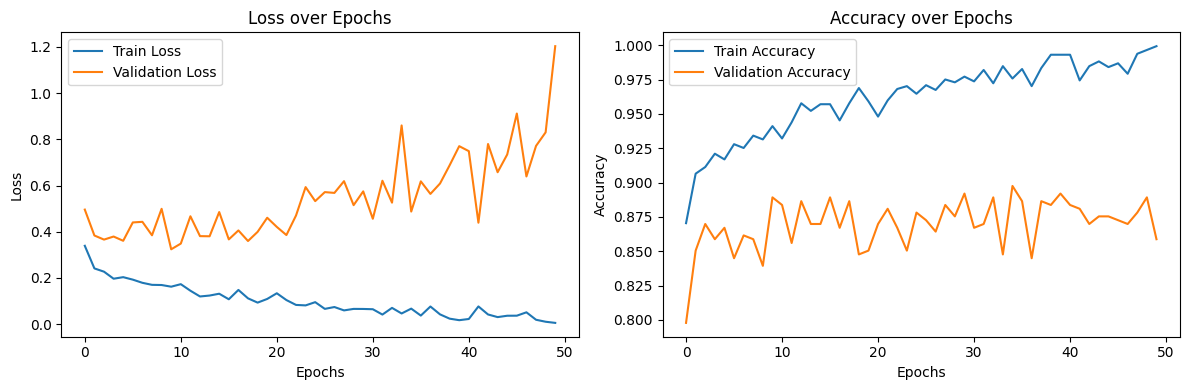

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(_.history['loss'], label='Train Loss')
plt.plot(_.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the accuracy for training and validation data
plt.subplot(1, 2, 2)
plt.plot(_.history['accuracy'], label='Train Accuracy')
plt.plot(_.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.savefig('fused_plots_inception.png', dpi=300)

plt.tight_layout()
plt.show()